# 3장

In [1]:
import numpy as np
c = np.array([[1, 0, 0, 0, 0, 0, 0]]) # 입력
W = np.random.randn(7, 3)             # 가중치
h = np.matmul(c, W)                   # 중간노드
print(h)

[[-0.6985814   0.1289135  -1.66773663]]


### CBOW model

In [11]:
import sys
sys.path.append('..')
import numpy as np
from common.layers import MatMul

# 샘플 맥락 데이터
c0 = np.array([[1, 0, 0, 0, 0, 0, 0]])
c1 = np.array([[0, 0, 1, 0, 0, 0, 0]])

# 가중치 초기화
W_in = np.random.randn(7, 3)
W_out = np.random.randn(3, 7)

# 계층 생성
in_layer0 = MatMul(W_in)
in_layer1 = MatMul(W_in)
out_layer = MatMul(W_out)

# 순전파
h0 = in_layer0.forward(c0)
h1 = in_layer1.forward(c1)
h = 0.5 * (h0 + h1)
s = out_layer.forward(h)

print(s)

[[-1.42125589 -0.70008503  0.57852047 -0.10326009 -1.53855671  1.26388103
  -1.15776949]]


###  말뭉치로부터 맥락과 타겟을 만드는 함수

In [13]:
import sys
sys.path.append('..')
from common.util import preprocess

text = "You say goodbye and i say hello"
corpus, word_to_id, id_to_word = preprocess(text)
print(corpus)

print(id_to_word)

[0 1 2 3 4 1 5]
{0: 'you', 1: 'say', 2: 'goodbye', 3: 'and', 4: 'i', 5: 'hello'}


### corpus로부터 맥락과 타겟을 만들아내는 함수

In [23]:
def create_contexts_target(corpus, window_size  = 1 ):
    target = corpus[window_size: -window_size]
    contexts = []
    
    for idx in range(window_size, len(corpus)-window_size):
        cs = []
        for t in range(-window_size, window_size + 1):
            if t == 0 :
                continue
            cs.append(corpus[idx+ t])
        contexts.append(cs)
        
    return np.array(contexts), np.array(target)

In [22]:
contexts, target = create_contexts_target(corpus, window_size=1)

print(contexts)
print(target)

[[0 2]
 [1 3]
 [2 4]
 [3 1]
 [4 5]]
[1 2 3 4 1]


### 웟 핫 표현으로 변환

In [25]:
import sys
sys.path.append("..")
from common.util import preprocess, create_contexts_target, convert_one_hot

text = 'You say goodbye and i say hello.'
corpus, word_to_id, id_to_word = preprocess(text)

contexts, target = create_contexts_target(corpus, window_size=1)

vocab_size = len(word_to_id)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

### CBOW 모델 구현 

In [28]:
import sys
sys.path.append("..")
import numpy as np
from common.layers import MatMul, SoftmaxWithLoss

class SimpleCBOW:
    def __init__(self, vocab_size, hidden_size):
        V, H = vocab_size, hidden_size
        
        # 가중치 초기화
        W_in = 0.01 * np.random.randn(V, H).astype('f')
        W_out = 0.01 * np.random.randn(H, V).astype('f')        
        
        # 계층 생성
        self.in_layer0 = MatMul(W_in)
        self.in_layer1 = MatMul(W_in)
        self.out_layer = MatMul(W_out)
        self.loss_layer = SoftmaxWithLoss()
        
        # 모든 가중치와 기울기를 리스트에 모음
        layers = [self.in_layer0, self.in_layer1, self.out_layer]
        self.params, self.grads = [], []
        for layer in layers:
            self.params += layer.params
            self.grads += layer.grads
            
        # 인스턴스 변수에 단어의 분산 표현을 저장함
        self.word_vecs = W_in
        
    def forward(self, contexts, target):
        h0 = self.in_layer0.forward(contexts[:, 0])
        h1 = self.in_layer1.forward(contexts[:, 1])
        h = (h0 + h1) * 0.5
        score = self.out_layer.forward(h)
        loss = self.loss_layer.forward(score, target)
        return loss
    
    def backward(self, dout=1):
        ds = self.loss_layer.backward(dout)
        da = self.out_layer.backward(ds)
        da *= 0.5
        self.in_layer1.backward(da)
        self.in_layer0.backward(da)
        return None

### 학습 코드 구현 

| 에폭 1 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 2 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 3 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 4 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 5 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 6 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 7 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 8 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 9 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 10 |  반복 1 / 2 | 시간 0[s] | 손실 1.95
| 에폭 11 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 12 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 13 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 14 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 15 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 16 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 17 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 18 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 19 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 20 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 21 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 22 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 23 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 24 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 25 |  반복 1 / 2 | 시간 0[s] | 손실 1.94
| 에폭 26 |

| 에폭 711 |  반복 1 / 2 | 시간 0[s] | 손실 0.46
| 에폭 712 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 713 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 714 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 715 |  반복 1 / 2 | 시간 0[s] | 손실 0.63
| 에폭 716 |  반복 1 / 2 | 시간 0[s] | 손실 0.58
| 에폭 717 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 718 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 719 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 720 |  반복 1 / 2 | 시간 0[s] | 손실 0.78
| 에폭 721 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 722 |  반복 1 / 2 | 시간 0[s] | 손실 0.48
| 에폭 723 |  반복 1 / 2 | 시간 0[s] | 손실 0.56
| 에폭 724 |  반복 1 / 2 | 시간 0[s] | 손실 0.61
| 에폭 725 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 726 |  반복 1 / 2 | 시간 0[s] | 손실 0.75
| 에폭 727 |  반복 1 / 2 | 시간 0[s] | 손실 0.47
| 에폭 728 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 729 |  반복 1 / 2 | 시간 0[s] | 손실 0.41
| 에폭 730 |  반복 1 / 2 | 시간 0[s] | 손실 0.69
| 에폭 731 |  반복 1 / 2 | 시간 0[s] | 손실 0.53
| 에폭 732 |  반복 1 / 2 | 시간 0[s] | 손실 0.65
| 에폭 733 |  반복 1 / 2 | 시간 0[s] | 손실 0.52
| 에폭 734 |  반복 1 / 2 | 시간 0[s] | 손실 0.64
| 에폭 735 |  반복 1

/Users/chan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 48373 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49552 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:240: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/Users/chan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:203: RuntimeWarning: Glyph 48152 missing from current font.
  font.set_text(s, 0, flags=flags)
/Users/chan/opt/anaconda3/lib/python3.9/site-packages/matplotlib/backend

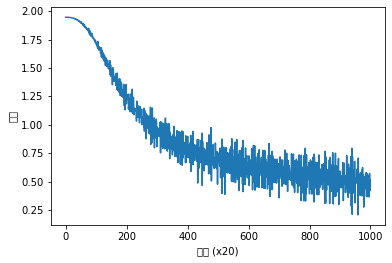

In [30]:
import sys
sys.path.append('..')
from common.trainer import Trainer
from common.optimizer import Adam
from common.util import preprocess, create_contexts_target, convert_one_hot

window_size = 1
hidden_size = 5
batch_size = 3
max_epoch = 1000

test = 'You say goodbye and i say hell.'
corpus, word_to_id, id_to_word = preprocess(text)

vocab_size = len(word_to_id)
contexts, target = create_contexts_target(corpus, window_size)
target = convert_one_hot(target, vocab_size)
contexts = convert_one_hot(contexts, vocab_size)

model = SimpleCBOW(vocab_size, hidden_size)
optimizer = Adam()
trainer = Trainer(model, optimizer)

trainer.fit(contexts, target, max_epoch, batch_size)
trainer.plot()

In [32]:
word_vecs = model.word_vecs
for word_id, word in id_to_word.items():
    print(word, word_vecs[word_id])

you [-1.5618126  -0.88819665  1.2169961   0.9223608   1.0800345 ]
say [ 1.2080061   1.1744959   0.01428598 -1.1802062  -0.3077422 ]
goodbye [-0.00285631 -0.9822193   0.77773553  0.91233283  0.89805585]
and [ 0.97449076  0.9536539   1.6507372  -0.9238877  -1.5635185 ]
i [-0.0039404  -0.9944434   0.7526492   0.91518664  0.9158116 ]
hello [-1.5606232  -0.88229465  1.2198662   0.9571887   1.0681202 ]
. [ 1.0795844  1.0406948 -1.367391  -1.0808773  1.6180795]
